## Data Prep

In [3]:
# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Set up the data
df_research = pd.read_csv('papers_with_models.csv')
df_released = pd.read_csv('Epoch Database - Notable Systems.csv')

df_research['date'] = pd.to_datetime(df_research['publication date (first revision)'])
df_research['year'] = pd.to_datetime(df_research['date']).dt.year
df_research['param count'] = pd.to_numeric(df_research['param count'], errors='coerce')
df_research['Type'] = 'Models used in research'

df_released['date'] = pd.to_datetime(df_released['Publication date'])
df_released['year'] = df_released['date'].dt.year
df_released['param count'] = pd.to_numeric(df_released['Parameters'], errors='coerce')
df_released['Type'] = 'Models released'

In [5]:
# Filter the published DataFrame to include only models from 2019 to 2024
df_released = df_released[(df_released['year'] >= 2019) & 
                            (df_released['year'] <= 2024)]

# Sort both DataFrames by date
df_research = df_research.sort_values(by='date')
df_published = df_released.sort_values(by='date')

# Filter for language models only
df_released = df_released[df_released['Domain'].str.contains('Language')]

# Filter for open models only 
df_released = df_released[df_released['Model accessibility'].str.contains('Open access', na=False)]

# Filter out rows with NaN in 'param_count'
df_released = df_released.dropna(subset=['param count'])

# - [ ] answer David about the skyline model


In [6]:
# Combine both DataFrames
df_combined = pd.concat([df_research[['year', 'date', 'param count', 'Type']], 
                         df_released[['year', 'date', 'param count', 'Type']]], ignore_index=True)

## Model Family Bar Chart

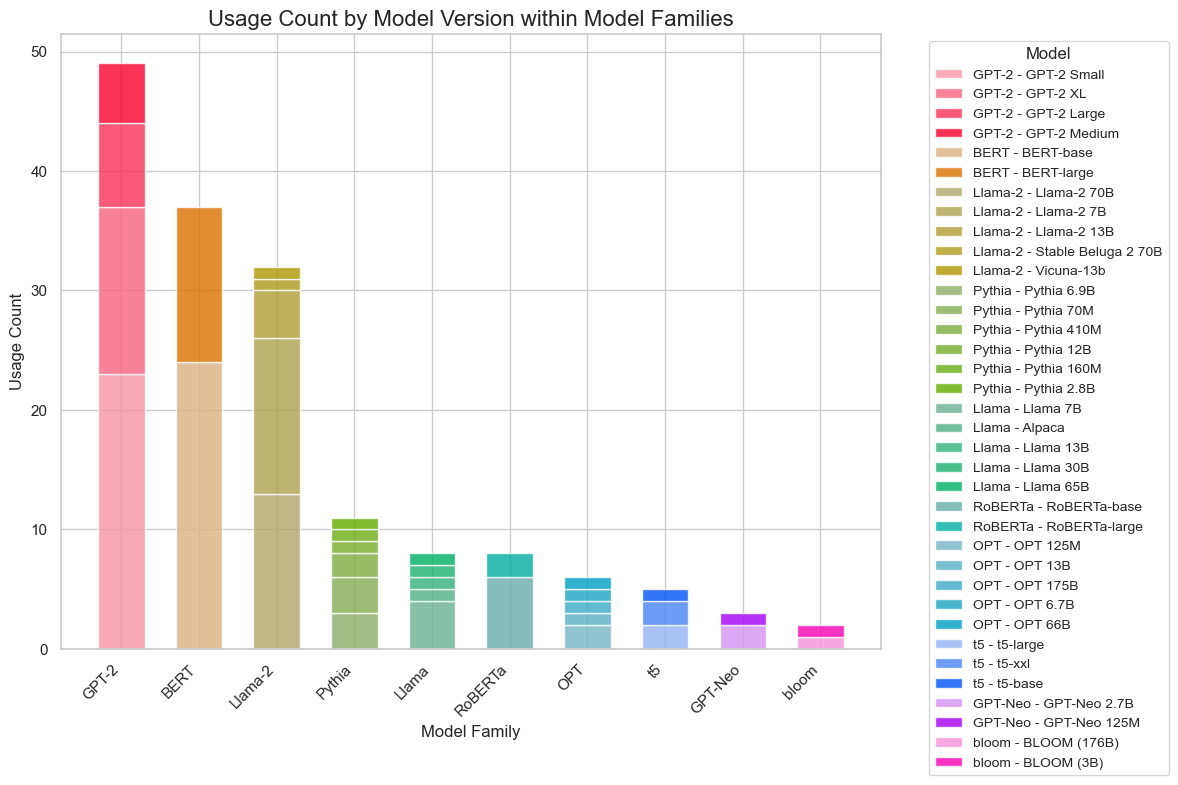

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import to_rgb, to_hex, rgb_to_hsv, hsv_to_rgb

# Assuming df_research is already loaded and contains the necessary columns

# Count the occurrences of each model within each family
grouped_data = df_research.groupby(['model family', 'model']).size().reset_index(name='usage_count')

# Count the number of unique models in each family
family_model_count = grouped_data.groupby('model family')['model'].nunique()

# Filter out families with only one model
families_to_keep = family_model_count[family_model_count > 1].index

# Filter the grouped data to keep only the selected families
grouped_data = grouped_data[grouped_data['model family'].isin(families_to_keep)]

# Calculate total usage count for each family
family_total_usage = grouped_data.groupby('model family')['usage_count'].sum().sort_values(ascending=False)

# Sort the data by total family usage count (descending) and then by model usage count within each family
grouped_data = grouped_data.set_index('model family').loc[family_total_usage.index].reset_index()
grouped_data = grouped_data.sort_values(['model family', 'usage_count'], ascending=[True, False])

# Get unique model families (now ordered by total usage)
model_families = family_total_usage.index

# Function to generate shades of a color
def generate_color_shades(base_color, n_shades):
    base_rgb = to_rgb(base_color)
    base_hsv = rgb_to_hsv(base_rgb)
    return [to_hex(hsv_to_rgb((base_hsv[0], s, base_hsv[2]))) for s in np.linspace(0.4, 1, n_shades)]

# Create a color palette for families
family_colors = sns.color_palette("husl", len(model_families))
family_color_dict = dict(zip(model_families, [to_hex(color) for color in family_colors]))

# Create the plot
plt.figure(figsize=(12, 8))

# Initialize variables for stacking
bottoms = np.zeros(len(model_families))
width = 0.6

# Plot each model as a stacked bar
for family in model_families:
    family_data = grouped_data[grouped_data['model family'] == family]
    n_models = len(family_data)
    color_shades = generate_color_shades(family_color_dict[family], n_models)
    
    for i, (_, row) in enumerate(family_data.iterrows()):
        height = row['usage_count']
        family_index = list(model_families).index(family)
        
        plt.bar(family_index, height, width, bottom=bottoms[family_index], 
                color=color_shades[i], label=f"{family} - {row['model']}", alpha=0.8)
        
        bottoms[family_index] += height

# Customize the plot
plt.title('Usage Count by Model Version within Model Families', fontsize=16)
plt.xlabel('Model Family', fontsize=12)
plt.ylabel('Usage Count', fontsize=12)
plt.xticks(range(len(model_families)), model_families, rotation=45, ha='right')

# Add legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Box Plot


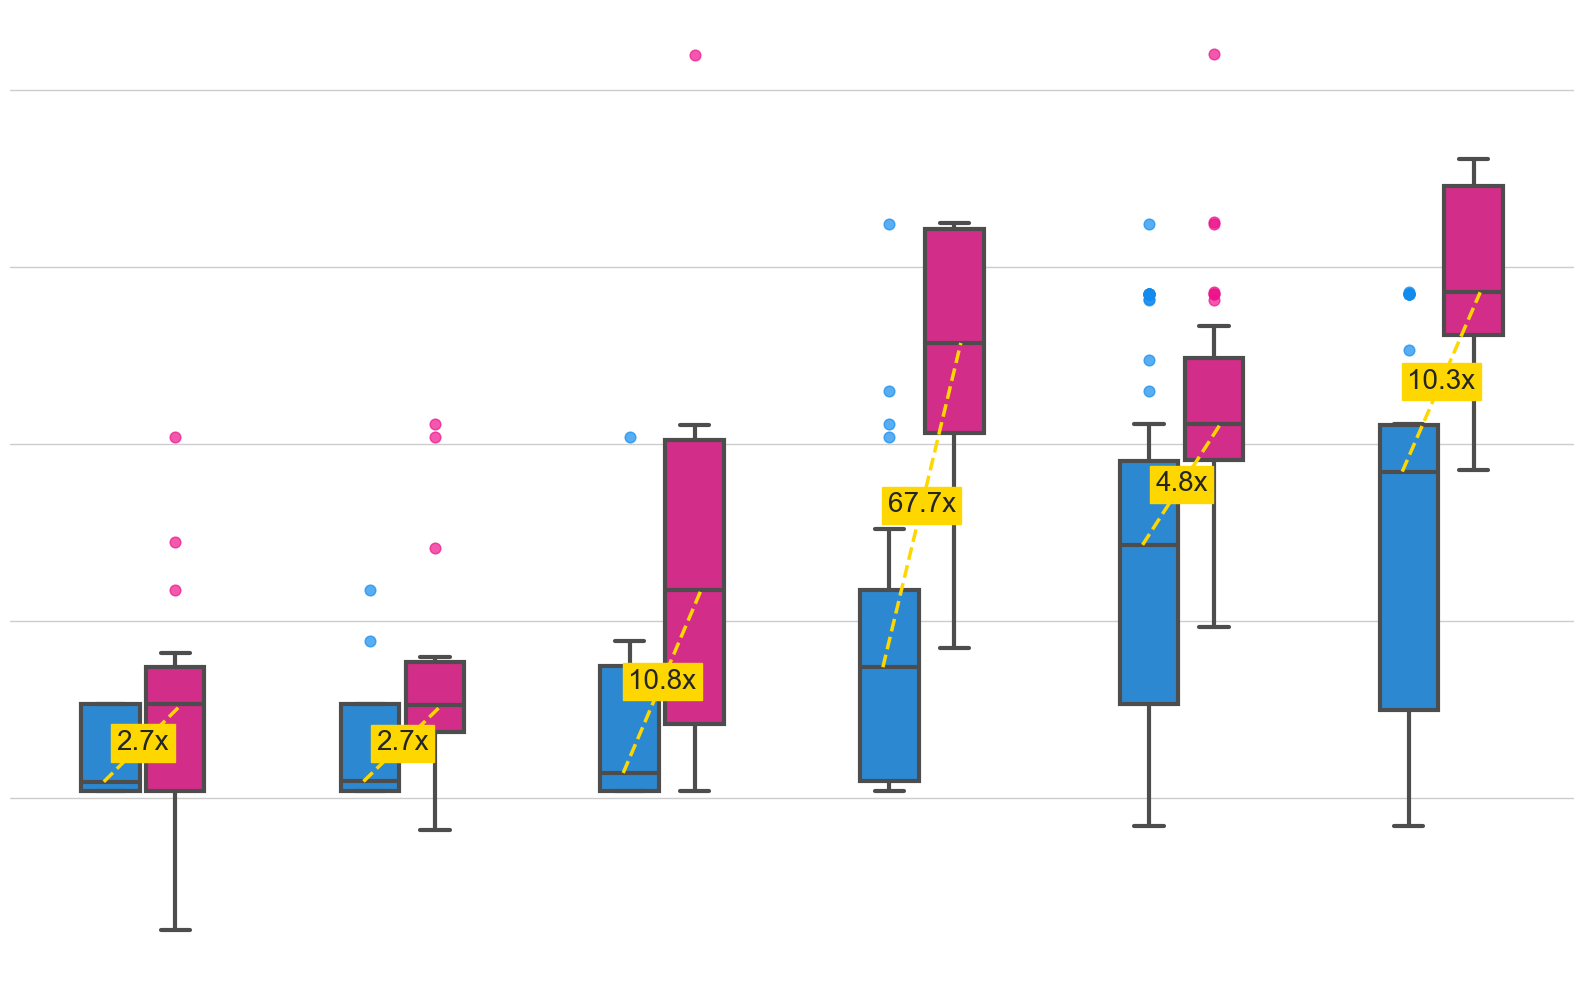

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set the theme before plotting
sns.set_theme(style="whitegrid")

plt.figure(figsize=(16, 10))
palette = {'Models used in research': '#118BEE', 'Models released': '#EE118B'}

# Define the order of 'Type' and 'year' for consistency
hue_order = ['Models used in research', 'Models released']
year_order = sorted(df_combined['year'].unique())

# Create boxplot without fliers and with specified order
ax = sns.boxplot(x='year', y='param count', hue='Type', data=df_combined, palette=palette, order=year_order, hue_order=hue_order, width=0.5, linewidth=3, showfliers=False, gap=0.1)

# Set the Y-axis to a logarithmic scale
ax.set_yscale('log')

# # Add titles and labels
# ax.set_title('Distribution of Model Sizes by Year', fontsize=24, fontweight='bold', pad=20)
# ax.set_xlabel('Year', fontsize=18, fontweight='bold', labelpad=15)
# ax.set_ylabel('Model Size (Number of Parameters)', fontsize=18, fontweight='bold', labelpad=15)

# Customize tick labels
# ax.tick_params(axis='both', which='major', labelsize=14)

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Hide all axis labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Remove x and y labels
ax.set_xlabel('')
ax.set_ylabel('')

# Calculate and plot median values with connecting lines
for i, year in enumerate(year_order):
    medians = [df_combined[(df_combined['year'] == year) & (df_combined['Type'] == t)]['param count'].median() for t in ['Models used in research', 'Models released']]
    
    if not any(np.isnan(medians)):
        x1, x2 = i - 0.15, i + 0.15
        plt.plot([x1, x2], medians, color='gold', linestyle='--', linewidth=2.5, zorder=5)
        gap_ratio = max(medians) / min(medians)
        plt.text(i, np.sqrt(medians[0] * medians[1]), f'{gap_ratio:.1f}x',
                 ha='center', va='center',
                 bbox=dict(facecolor='gold', edgecolor='gold', alpha=1),
                 fontsize=20, zorder=20)

# Prepare outlier data using the IQR method
def is_outlier(s):
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    return (s < q1 - 1.5 * iqr) | (s > q3 + 1.5 * iqr)

outlier_data = df_combined.groupby(['year', 'Type']).apply(lambda x: x[is_outlier(x['param count'])]).reset_index(drop=True)

# Create a mapping from (year, Type) to x positions
# First, get the number of hue levels
n_hues = len(hue_order)
# Calculate the width of each box
box_width = 0.5
# Total dodge range
dodge_range = box_width / n_hues

# Create a dictionary to map (year, Type) to specific x positions
x_offsets = {t: (i - 0.5) * dodge_range for i, t in enumerate(hue_order)}

# Plot outliers manually using plt.scatter for precise alignment
for _, row in outlier_data.iterrows():
    # Check if the year is in our ordered list
    year_index = year_order.index(row['year']) if row['year'] in year_order else None
    if year_index is not None:
        # Calculate x position and plot the outlier
        x_pos = year_index + x_offsets.get(row['Type'], 0)
        plt.scatter(
            x_pos,
            row['param count'],
            color=palette.get(row['Type']),
            linewidth=1, alpha=0.7, s=60, zorder=15 
        )

ax.legend(title='Model Type', title_fontsize='16', fontsize='14', loc='upper left', frameon=True)
# Remove the legend
ax.get_legend().remove()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
# Save the figure as SVG
plt.savefig('boxplot.svg', format='svg', dpi=300, bbox_inches='tight')

plt.show()

## Median and Max Gaps

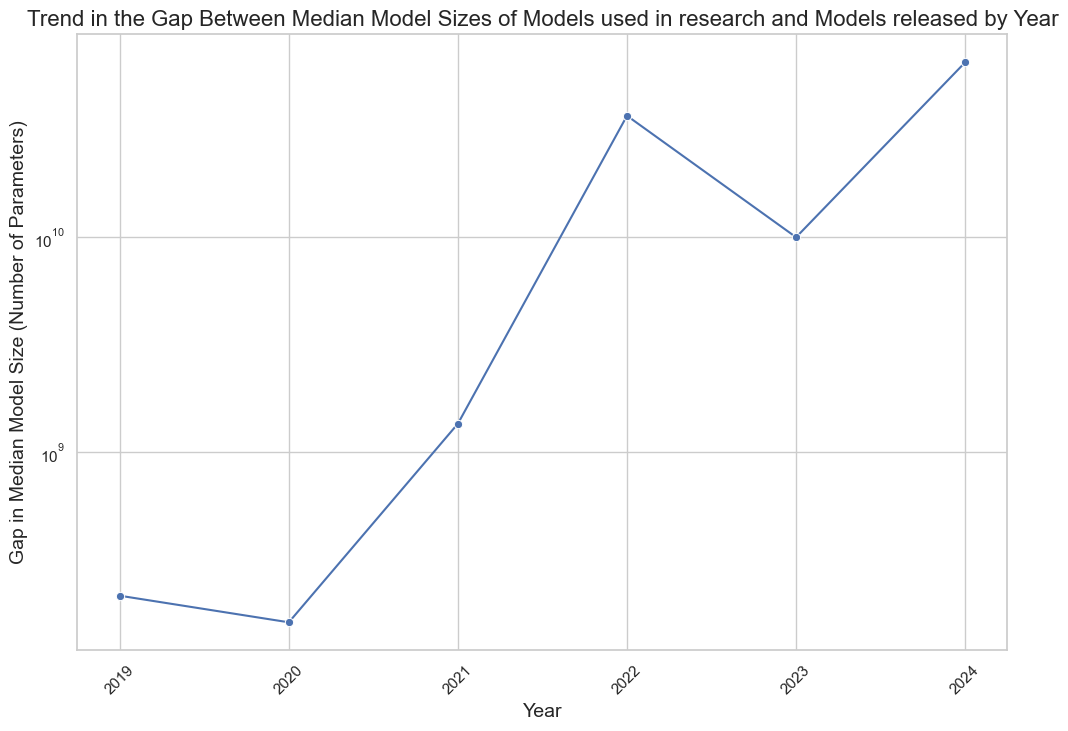

In [26]:
# Calculate the median model size for each year and type
median_sizes = df_combined.groupby(['year', 'Type'])['param count'].median().reset_index()

# Pivot the DataFrame to have 'year' as the index and 'Type' as columns
median_pivot = median_sizes.pivot(index='year', columns='Type', values='param count')

# Calculate the gap between the median sizes
median_pivot['Gap'] =  median_pivot['Models released'] - median_pivot['Models used in research']

# Plot the trend in the gap
plt.figure(figsize=(12, 8))

sns.lineplot(data=median_pivot, x=median_pivot.index, y='Gap', marker='o')

# Set y-axis to log scale
plt.yscale('log')

# Add titles and labels
plt.title('Trend in the Gap Between Median Model Sizes of Models used in research and Models released by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Gap in Median Model Size (Number of Parameters)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

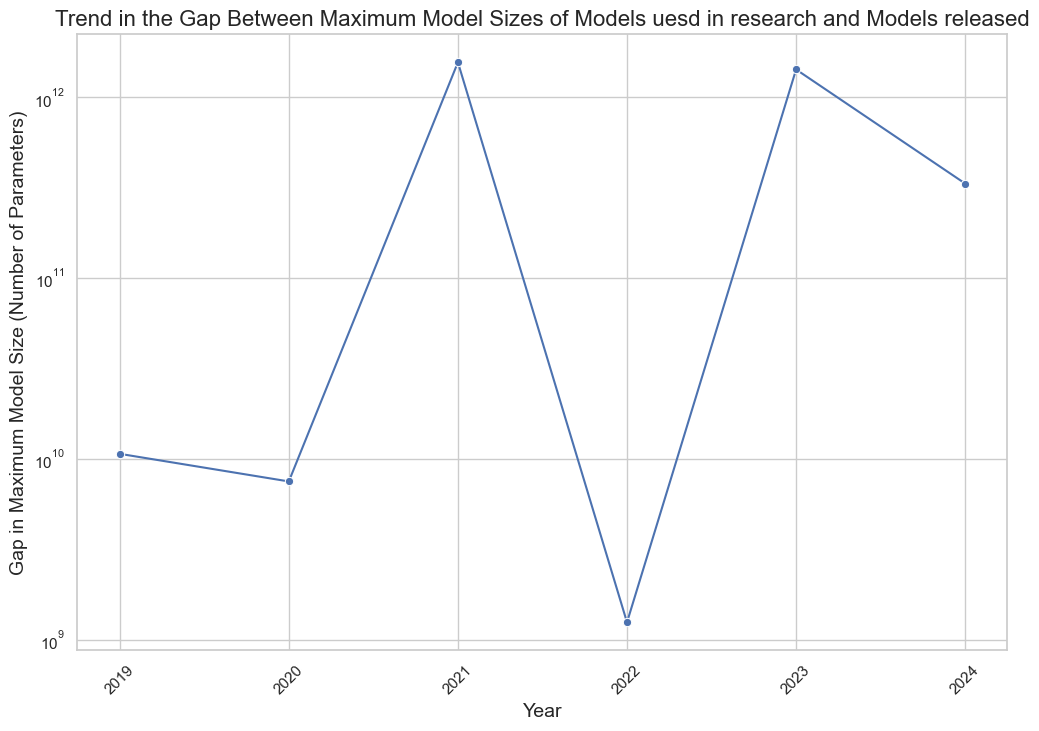

In [27]:

# Calculate the maximum model size for each year and type
max_sizes = df_combined.groupby(['year', 'Type'])['param count'].max().reset_index()

# Pivot the DataFrame to have 'year' as the index and 'Type' as columns
max_pivot = max_sizes.pivot(index='year', columns='Type', values='param count')

# Calculate the gap between the maximum sizes
max_pivot['Gap'] =  max_pivot['Models released'] - max_pivot['Models used in research']

# Plot the trend in the gap for maximum sizes
plt.figure(figsize=(12, 8))
sns.lineplot(data=max_pivot, x=max_pivot.index, y='Gap', marker='o')

# Set y-axis to log scale
plt.yscale('log')

# Add titles and labels
plt.title('Trend in the Gap Between Maximum Model Sizes of Models uesd in research and Models released', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Gap in Maximum Model Size (Number of Parameters)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

## Scatterplot (Rolling Median)

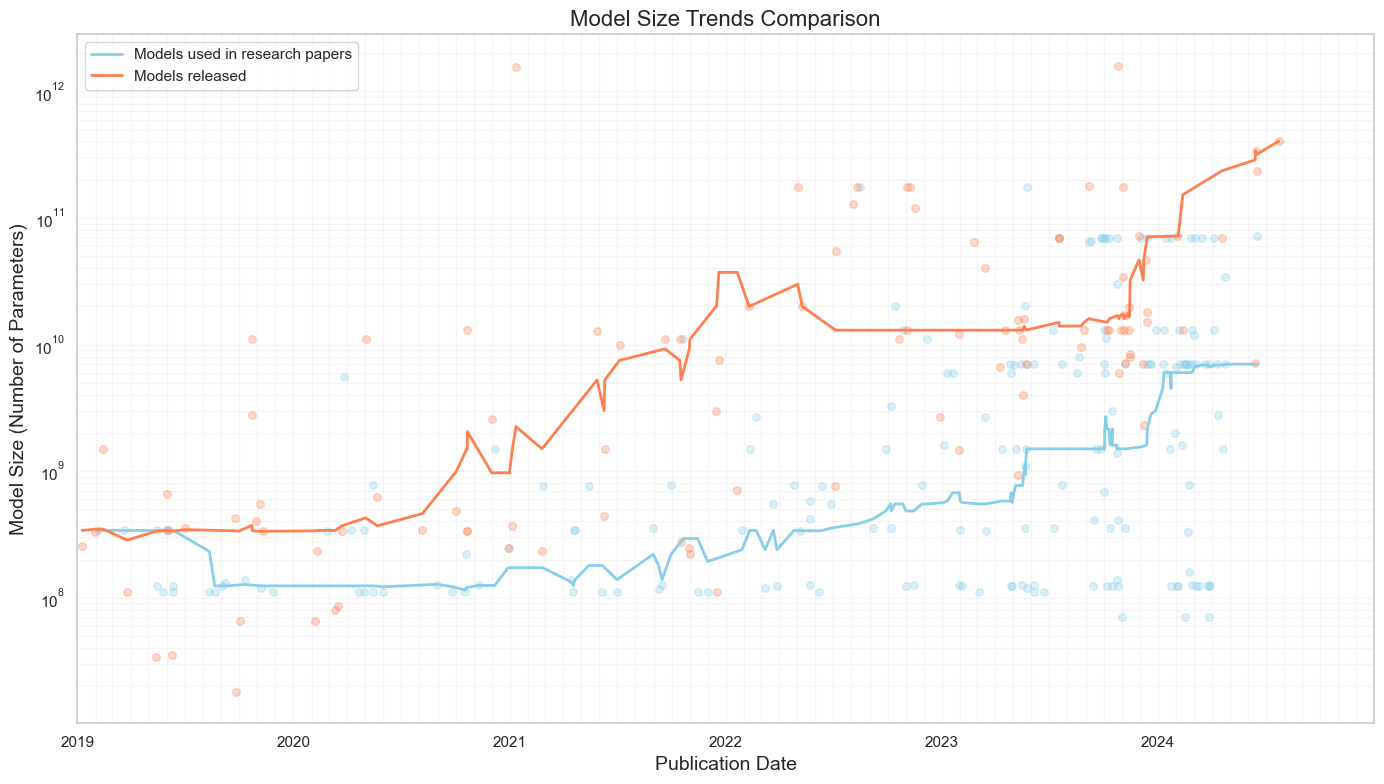

In [28]:
import matplotlib.dates as mdates

# Filter necessary columns before rolling operation
df_research_filtered = df_research[['date', 'param count']]
df_released_filtered = df_released[['date', 'param count']]

# Calculate rolling medians
df_research_rolling = df_research_filtered.set_index('date').rolling(window='360D').median().reset_index()
df_released_rolling = df_released_filtered.set_index('date').rolling(window='360D').median().reset_index()

# Set up the plot
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Create scatter plot
plt.scatter(df_research['date'], df_research['param count'], 
            color='skyblue', alpha=0.3, s=30)
plt.scatter(df_released['date'], df_released['param count'], 
            color='coral', alpha=0.3, s=30)

# Plot rolling mean lines
plt.plot(df_research_rolling['date'], df_research_rolling['param count'], 
         color='skyblue', linestyle='-', linewidth=2, label='Models used in research papers')
plt.plot(df_released_rolling['date'], df_released_rolling['param count'], 
         color='coral', linestyle='-', linewidth=2, label='Models released')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Set labels and title
ax.set_title('Model Size Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel('Model Size (Number of Parameters)', fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Scatterplot (LOWESS)

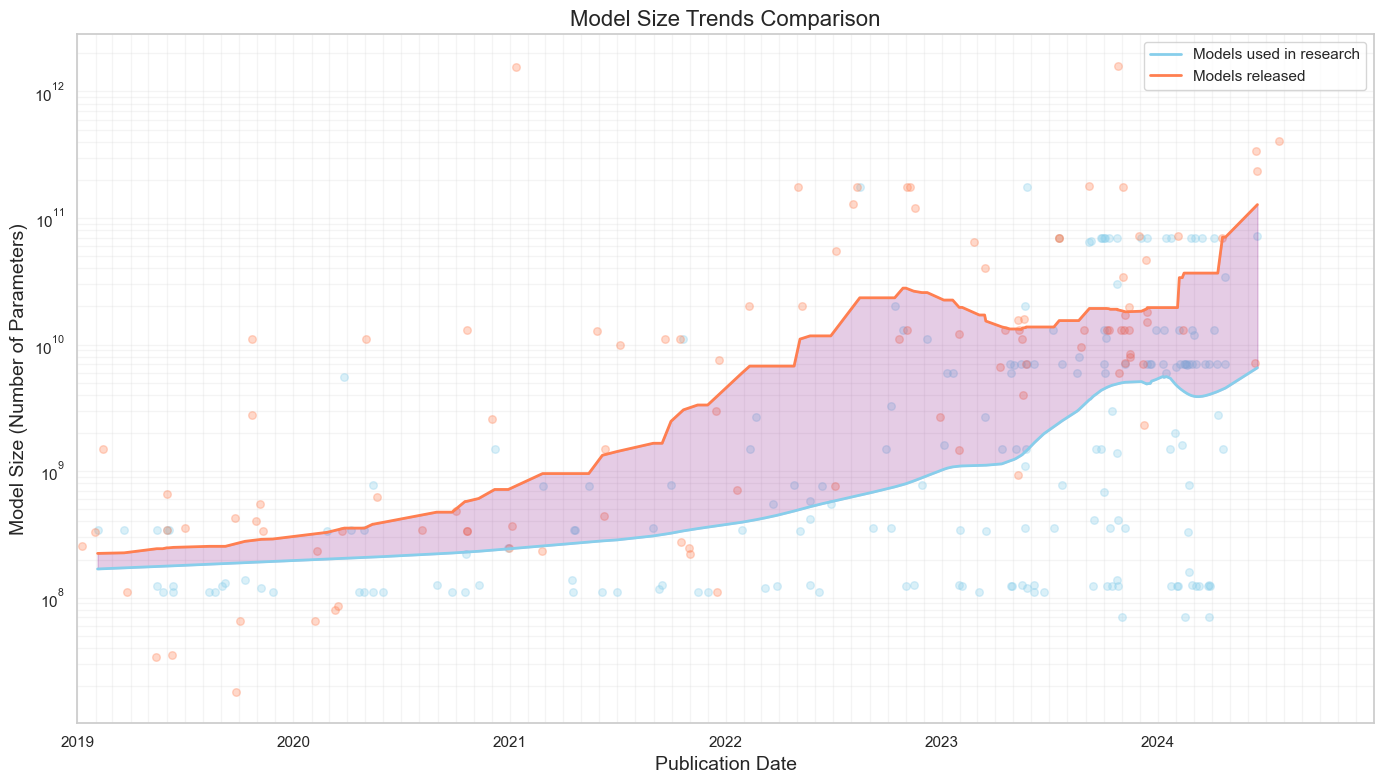

In [29]:
import matplotlib.dates as mdates
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set up the plot
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Create scatter plot
plt.scatter(df_research['date'], df_research['param count'], 
            color='skyblue', alpha=0.3, s=30)
plt.scatter(df_released['date'], df_released['param count'], 
            color='coral', alpha=0.3, s=30)

# Function to calculate LOWESS
def lowess_trend(x, y, f=1./3.):
    return lowess(y, x, frac=f)

# Calculate LOWESS trends
lowess_research = lowess_trend(df_research['date'].astype(int), np.log10(df_research['param count']))
lowess_published = lowess_trend(df_released['date'].astype(int), np.log10(df_released['param count']))

# Convert LOWESS results to DataFrames for easier manipulation
df_lowess_research = pd.DataFrame({'date': pd.to_datetime(lowess_research[:, 0]), 'trend': 10**lowess_research[:, 1]})
df_lowess_published = pd.DataFrame({'date': pd.to_datetime(lowess_published[:, 0]), 'trend': 10**lowess_published[:, 1]})

# Merge the two LOWESS DataFrames
df_lowess_merged = pd.merge_asof(df_lowess_research, df_lowess_published, on='date', suffixes=('_research', '_published'))

# Plot LOWESS trends
plt.plot(df_lowess_merged['date'], df_lowess_merged['trend_research'], 
         color='skyblue', linestyle='-', linewidth=2, label='Models used in research')
plt.plot(df_lowess_merged['date'], df_lowess_merged['trend_published'], 
         color='coral', linestyle='-', linewidth=2, label='Models released')

# Add shaded area between the lines
plt.fill_between(df_lowess_merged['date'], 
                 df_lowess_merged['trend_research'], 
                 df_lowess_merged['trend_published'], 
                 alpha=0.2, color='purple')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Set labels and title
ax.set_title('Model Size Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel('Model Size (Number of Parameters)', fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Scatterplot (Linear Regression)

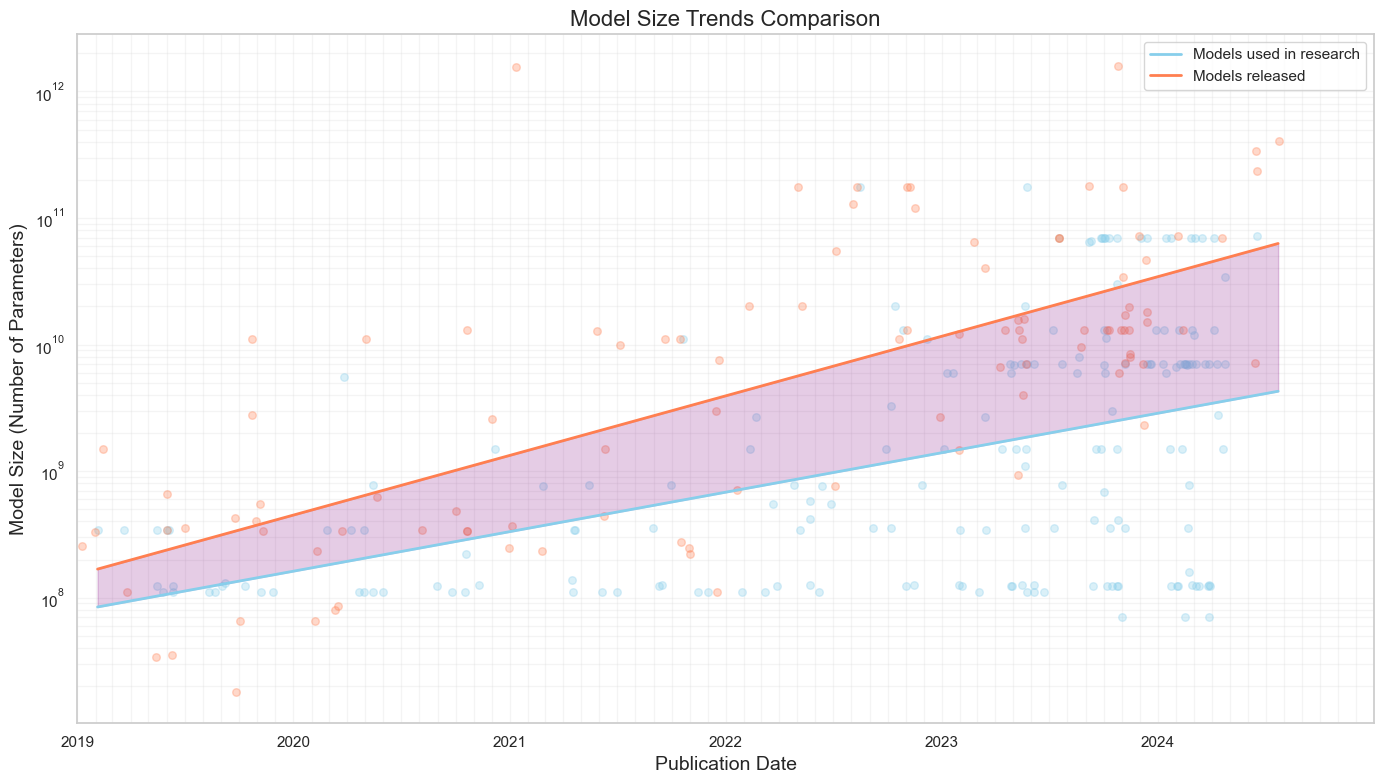

In [6]:
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

# Set up the plot
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Create scatter plot
plt.scatter(df_research['date'], df_research['param count'], 
            color='skyblue', alpha=0.3, s=30)
plt.scatter(df_released['date'], df_released['param count'], 
            color='coral', alpha=0.3, s=30)

# Function to perform linear regression
def linear_trend(x, y):
    x = x.values.reshape(-1, 1)  # Reshape for linear regression
    model = LinearRegression()
    model.fit(x, np.log10(y))
    return model

# Convert dates to ordinal (numeric format for regression)
df_research['date_ordinal'] = df_research['date'].map(pd.Timestamp.toordinal)
df_released['date_ordinal'] = df_released['date'].map(pd.Timestamp.toordinal)

# Fit linear regression models
model_research = linear_trend(df_research['date_ordinal'], df_research['param count'])
model_released = linear_trend(df_released['date_ordinal'], df_released['param count'])

# Generate trend lines
x_vals = np.arange(df_research['date_ordinal'].min(), df_released['date_ordinal'].max()).reshape(-1, 1)
research_trend = 10**model_research.predict(x_vals)
released_trend = 10**model_released.predict(x_vals)

# Convert ordinal values back to dates
dates = pd.to_datetime([pd.Timestamp.fromordinal(int(x)) for x in x_vals])

# Plot linear regression trends
plt.plot(dates, research_trend, color='skyblue', linestyle='-', linewidth=2, label='Models used in research')
plt.plot(dates, released_trend, color='coral', linestyle='-', linewidth=2, label='Models released')

# Add shaded area between the lines
plt.fill_between(dates, research_trend, released_trend, alpha=0.2, color='purple')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Set labels and title
ax.set_title('Model Size Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel('Model Size (Number of Parameters)', fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
